In [1]:
#Importing all modules which are important for this excersize
import scipy.io
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

In [143]:
# Loading the camera data
cam1 = scipy.io.loadmat('cam1.mat')
cam2 = scipy.io.loadmat('cam2.mat')
cam3 = scipy.io.loadmat('cam3.mat')

# Checking the structure of the dictionary in the dataset
print(cam1.keys())
print(cam2.keys())
print(cam3.keys())

# Extracting the frames from the Dataset using their respective keys
cam_1 = cam1['vidFrames1_4']
cam_2 = cam2['vidFrames2_4']
cam_3 = cam3['vidFrames3_4']

dict_keys(['__header__', '__version__', '__globals__', 'vidFrames1_4'])
dict_keys(['__header__', '__version__', '__globals__', 'vidFrames2_4'])
dict_keys(['__header__', '__version__', '__globals__', 'vidFrames3_4'])


In [147]:
# Printing the shape of the dataset and the datatype to check if i can be manipulated directly using python
print(cam_1.shape)
print(cam_1.dtype)

(480, 640, 3, 392)
uint8


In [149]:
# Creating a cropping function to be used to process the dataset

def crop_dataset(dataset, x_min, x_max, y_min, y_max):
    """
    Crops the dataset to the given pixel range without rotating.

    Parameters:
    - dataset: numpy array (Height, Width, Colour Channels, Frames) - Video dataset 
    - x_min, x_max: int - Pixel range for cropping in the X direction
    - y_min, y_max: int - Pixel range for cropping in the Y direction

    Returns:
    - Processed dataset (cropped)
    """
    num_frames = dataset.shape[3]  # Extract the number of frames

    # Initialize an empty array to store the processed dataset
    processed_dataset = np.zeros((y_max - y_min, x_max - x_min, 3, num_frames), dtype=np.uint8)

    for i in range(num_frames):
        frame = dataset[:, :, :, i]  # Extract the i-th frame
        cropped_frame = frame[y_min:y_max, x_min:x_max]  # Crop the frame
        processed_dataset[:, :, :, i] = cropped_frame  # Store the processed frame

    return processed_dataset  # Return the cropped dataset

In [153]:
# Creating a function which will allow us to rotate the dataset, neccesary as dataset 3 is rotated by 90 degrees

def rotate_dataset(dataset, rotation_angle):
    """
    Rotates the dataset clockwise by the given angle without cropping.

    Parameters:
    - dataset: numpy array (Height, Width, Colour Channels, Frames) - Video dataset
    - rotation_angle: float - Rotation angle in degrees (clockwise)

    Returns:
    - Processed dataset (rotated without cropping)
    """
    num_frames = dataset.shape[3]  # Extract the number of frames
    h, w = dataset.shape[:2]  # Original height and width

    # Initialize an array for the rotated dataset
    rotated_dataset = np.zeros_like(dataset)

    for i in range(num_frames):
        frame = dataset[:, :, :, i]  # Extract the i-th frame

        # Rotate the frame
        center = (w // 2, h // 2)  # Compute centre (half of the width and height)
        rotation_matrix = cv2.getRotationMatrix2D(center, -rotation_angle, 1)  # Use the rotation matrix (neg for clockwise rotation)
        rotated_frame = cv2.warpAffine(frame, rotation_matrix, (w, h))  # Apply the rotation matrix to the dataset

        # Store the processed frame
        rotated_dataset[:, :, :, i] = rotated_frame

    return rotated_dataset  # return the result

In [155]:
#Creating a function to convert the dataset into a video.
# Neccesary in order to review if the cropping was done correctly and later on to watch the tracking results

def create_video_from_dataset(dataset, output_video, fps=30):
    """
    Creates a video file from a dataset of frames.
    
    Parameters:
    - dataset: numpy array (Height, Width, Colour Channels, Frames) - Processed video frames.
    - output_video: str - Output video filename and path.
    - fps: int - Frames per second.
    
    Returns:
    - None (saves the video file)
    """
    num_frames = dataset.shape[3]  # Extract the number of frames
    height, width = dataset.shape[:2]  # Extract the frame height and width
    fourcc = cv2.VideoWriter_fourcc(*'avc1')  # Use 'avc1'' instead of 'mp4' due to compression issues
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))  # Create the videwriter

    # Cycle through each frame 
    for i in range(num_frames):  
        frame = dataset[:, :, :, i]  # Extract the image in all 3 channels from each frame
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert the image to Blue Green Red as expected by OpenCV
        out.write(frame_bgr)  # Write the frame onto the video
    
    out.release()  # Release the video onto the specified path
    print(f"Video saved: {output_video}")  # Print the video location to confirm succesful operation


In [156]:
# Creating a function to save dataset as a numpy archive to be able to loead it without loading the whole mat file

def save_dataset(data, filename):
    """
    Saves a cropped dataset into an .npz file under the key 'data'.

    Parameters:
    - data (numpy.ndarray): The cropped dataset to save. Expected shape: (Height, Width, Colour Channels, Frames).
    - filename (str): The path where the dataset should be saved (must end with .npz).

    Returns:
    - None
    """
    
    np.savez_compressed(filename, data=data)  # Save the dataset in the specified location
    print(f"Dataset saved successfully to '{filename}'.")  # Print location to confirm succesful operation


In [5]:
# Cropping the videos using the developed function 
dataset1 = crop_dataset(cam_1, 300, 500, 220, 450)  # Crop Dataset 1

dataset2 = crop_dataset(cam_2, 200, 480, 60, 400)  # Crop Dataset 2

cropped_dataset3 = crop_dataset(cam_3, 300, 500, 130, 300)  # Crop Dataset 3

dataset3 = rotate_dataset(cropped_dataset3, 90)  # Rotate Dataset 3 by 90 degrees

In [161]:
# Since this the first time we are saving a figure, make sure that the directory 'plots' where we want to save exists
output_dir = "plots"  # Output directory to be created in the current folder
os.makedirs(output_dir, exist_ok=True)  # IF it doesn't exist, create it

# Extract the cropped and original frames to compare them for the purpose of the report
first_frame = cam_2[:, :, :, 80]  
cropped_frame = dataset2[:, :, :, 80]  

# Plot and save the original frame
plt.figure()  # Create a new figure for the original frame
plt.imshow(first_frame)  # Display the original frame as an image
#plt.title("Original Frame")  # Title is commented out to keep the image clean
plt.axis("off")  # Removes axes to avoid extra padding around the image
original_plot_path = os.path.join(output_dir, "original_frame.png")  # Define the path to save the original frame
plt.savefig(original_plot_path, dpi=300, bbox_inches='tight', pad_inches=0)  # Save the figure with tight bounding box and no extra padding
#plt.show()  # Display the figure
plt.close()  # Close the figure to free up memory

# Plot and save the cropped frame
plt.figure()  # Create a new figure for the cropped frame
plt.imshow(cropped_frame)  # Display the cropped frame as an image
#plt.title("Cropped Frame")  # Title is commented out to keep the image clean
plt.axis("off")  # Removes axes for cleaner visualization
cropped_plot_path = os.path.join(output_dir, "cropped_frame.png")  # Define the path to save the cropped frame
plt.savefig(cropped_plot_path, dpi=300, bbox_inches='tight', pad_inches=0)  # Save the figure with tight bounding box and no extra padding
#plt.show()  # Display the figure
plt.close()  # Close the figure to free up memory

# Return saved plot paths
(original_plot_path, cropped_plot_path)

('plots/original_frame.png', 'plots/cropped_frame.png')

In [7]:
# Using the developed function to create a video from cropped datasets
create_video_from_dataset(dataset1, "videos/cam1.mp4", fps=30)
create_video_from_dataset(dataset2, "videos/cam2.mp4", fps=30) 
create_video_from_dataset(dataset3, "videos/cam3.mp4", fps=30)

Video saved: videos/cam1.mp4
Video saved: videos/cam2.mp4
Video saved: videos/cam3.mp4


In [8]:
# Compress datasets and save them so that all steps dont need to be repeated when reopening the file
save_dataset(dataset1, "camera1_cropped.npz")
save_dataset(dataset2, "camera2_cropped.npz")
save_dataset(dataset3, "camera3_cropped.npz")

Dataset saved successfully to 'camera1_cropped.npz'.
Dataset saved successfully to 'camera2_cropped.npz'.
Dataset saved successfully to 'camera3_cropped.npz'.


In [162]:
# An example frame with the processing applied to it is extracted for showcasing in the report - frame 80 from dataset 2

# Extracting the frame from dataset2 at frame index 80
frame = dataset2[:, :, :, 80]

# Step 1: Convert to Grayscale
gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert the RGB frame to grayscale
plt.figure()  # Create a new figure for grayscale frame
plt.imshow(gray_frame, cmap="gray")  # Display grayscale image with a gray colormap
#plt.title("Grayscale Frame")  # Title is commented out for a clean appearance
plt.axis("off")  # Remove axes for a cleaner visualization
gray_path = os.path.join(output_dir, "frame_gray.png")  # Define the save path for grayscale image
plt.savefig(gray_path, dpi=300, bbox_inches='tight', pad_inches=0)  # Save the grayscale frame
plt.close()  # Close figure to free up memory

# Step 2: Apply Histogram Equalization
equalized_frame = cv2.equalizeHist(gray_frame)  # Apply histogram equalization to enhance contrast
plt.figure()  # Create a new figure for equalized frame
plt.imshow(equalized_frame, cmap="gray")  # Display histogram-equalized image
#plt.title("Histogram Equalized Frame")  # Title is commented out for a clean appearance
plt.axis("off")  # Remove axes for better visualization
equalized_path = os.path.join(output_dir, "frame_equalized.png")  # Define the save path for histogram-equalized frame
plt.savefig(equalized_path, dpi=300, bbox_inches='tight', pad_inches=0)  # Save the equalized frame
plt.close()  # Close figure to free up memory

# Step 3: Apply Gaussian Blur
blurred_frame = cv2.GaussianBlur(equalized_frame, (5, 5), 0)  # Apply Gaussian blur with a 5x5 kernel to smooth image
plt.figure()  # Create a new figure for blurred frame
plt.imshow(blurred_frame, cmap="gray")  # Display blurred image
#plt.title("Gaussian Blurred Frame")  # Title is commented out for a clean appearance
plt.axis("off")  # Remove axes for better visualization
blurred_path = os.path.join(output_dir, "frame_blurred.png")  # Define the save path for blurred frame
plt.savefig(blurred_path, dpi=300, bbox_inches='tight', pad_inches=0)  # Save the blurred frame
plt.close()  # Close figure to free up memory

# Return paths of saved images
(gray_path, equalized_path, blurred_path)


('plots/frame_gray.png',
 'plots/frame_equalized.png',
 'plots/frame_blurred.png')

In [165]:
# Function to track an object in a video dataset using template matching
def track_object_in_video(dataset_path, template_coords, template_frame_index=0, match_threshold=0.65, max_move_distance=20, output_video='tracked_video.mp4', sample_index=100):
    """
    Tracks an object in a video dataset using template matching.

    Parameters:
    - dataset_path: str - Path to the .npz dataset containing video frames.
    - template_coords: tuple - (x, y, width, height) defining the template region.
    - match_threshold: float - Minimum acceptable match score.
    - max_move_distance: int - Maximum allowed movement (in pixels) between consecutive frames.
    - output_video: str - Filename for saving the output tracked video.
    - sample_index: int - Index of a frame to visualize results.

    Returns:
    - tracked_positions: np.ndarray - Array of tracked positions (x, y) per frame.
    """

    # Load the dataset from the specified file path
    data = np.load(dataset_path)

    # Extract the video frames from the dataset
    video_frames = data["data"]  # Expected shape: (Height, Width, 3, Frames)

    # Get the total number of frames in the dataset
    num_frames = video_frames.shape[3]
    
    # Print the number of frames for debugging purposes
    print("Number of frames:", num_frames)

    # Extract template coordinates (x, y position, width, and height)
    template_x, template_y, template_w, template_h = template_coords
    
    # Select the first frame to extract the template
    first_frame = video_frames[:, :, :, template_frame_index]

    # Convert the first frame to grayscale for easier processing
    gray_first = cv2.cvtColor(first_frame, cv2.COLOR_RGB2GRAY)

    # Apply histogram equalization to enhance contrast in the grayscale image
    equalized_first = cv2.equalizeHist(gray_first)

    # Apply Gaussian blur to reduce noise in the image
    blurred_first = cv2.GaussianBlur(equalized_first, (5,5), 0)

    # Extract the template from the processed first frame using the provided coordinates
    template = blurred_first[template_y:template_y+template_h, template_x:template_x+template_w]

    # Display the full frame with axes labeled for template selection
    plt.figure(figsize=(8,8))  # Create a figure with a specified size
    plt.imshow(gray_first, cmap="gray")  # Display grayscale image
    plt.title("Full Frame with Axes for Template Selection")  # Add title
    plt.xlabel("Width (pixels)")  # Label x-axis
    plt.ylabel("Height (pixels)")  # Label y-axis
    plt.grid(True)  # Enable grid
    plt.show()  # Show the figure
    plt.close()  # Close the figure to free up memory
    
    # Display the selected template region
    plt.figure(figsize=(4,4))  # Create a smaller figure
    plt.imshow(template, cmap="gray")  # Display grayscale template
    plt.title("Selected Template Region")  # Add title
    plt.axis("off")  # Remove axes for cleaner display
    plt.show()  # Show the figure
    plt.close()  # Close the figure to free up memory
    
    # Initialize an array to store the tracked positions (x, y) for each frame
    tracked_positions = np.zeros((num_frames, 2))

    # Create a copy of the video frames for overlaying tracking results
    overlay_frames = np.copy(video_frames).astype(np.uint8)

    # Iterate through each frame in the dataset
    for i in range(num_frames):
        
        # Extract the current frame
        frame = video_frames[:, :, :, i]
        
        # Convert the current frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

        # Apply histogram equalization to enhance contrast
        equalized = cv2.equalizeHist(gray)

        # Apply Gaussian blur to reduce noise and smooth the image
        blurred = cv2.GaussianBlur(equalized, (5,5), 0)
        
        # Perform template matching to find the best match in the current frame
        result = cv2.matchTemplate(blurred, template, cv2.TM_CCOEFF_NORMED)

        # If it's the first frame, initialize tracking position based on highest match
        if i == 0:
            _, max_val, _, max_loc = cv2.minMaxLoc(result)  # Find the max location
            top_left = max_loc  # Store top-left corner of best match
            center = (top_left[0] + template_w // 2, top_left[1] + template_h // 2)  # Compute center of match
        
        else:
            # Sort matching scores in descending order
            sorted_indices = np.argsort(-result.ravel())

            # Initialize flag for best candidate detection
            best_candidate_found = False
            
            # Get the previous detected center for distance comparison
            prev_center = tracked_positions[i-1]

            # Iterate through sorted matching scores
            for idx in sorted_indices:
                r, c = np.unravel_index(idx, result.shape)  # Get row and column from flattened index
                candidate_score = result[r, c]  # Get the match score

                # If the candidate score is below the threshold, stop searching
                if candidate_score < match_threshold:
                    break

                # Compute the candidate object's center position
                candidate_center = (c + template_w // 2, r + template_h // 2)

                # Compute the distance between the previous and new detected center
                distance = np.linalg.norm(np.array(candidate_center) - np.array(prev_center))

                # Check if the movement is within the allowed distance threshold
                if distance <= max_move_distance:
                    best_candidate_found = True
                    top_left = (c, r)
                    center = candidate_center
                    break
            
            # If no valid match was found, assume the object remains in the previous position
            if not best_candidate_found:
                center = (int(prev_center[0]), int(prev_center[1]))  # Use previous center
                top_left = (center[0] - template_w // 2, center[1] - template_h // 2)  # Adjust bounding box
        
        # Store the tracked position for this frame
        tracked_positions[i] = center
        
        # Draw tracking results on the frame
        frame_to_draw = overlay_frames[:, :, :, i].copy()

        # Define the bottom-right corner of the bounding box
        bottom_right = (top_left[0] + template_w, top_left[1] + template_h)

        # Draw a green rectangle around the detected object
        cv2.rectangle(frame_to_draw, top_left, bottom_right, (255, 0, 0), 2)

        # Draw a red dot at the object's center
        cv2.circle(frame_to_draw, center, 3, (0, 255, 0), -1)

        # Store the overlayed frame
        overlay_frames[:, :, :, i] = frame_to_draw

    # Display a sample tracked frame (specified by `sample_index`)
    tracked_sample = overlay_frames[:, :, :, sample_index]
    plt.figure(figsize=(6,6))
    plt.imshow(tracked_sample)
    plt.axis("off")  # Remove axes for cleaner display
    plt.savefig('plots/tracked_image.png', dpi=300, bbox_inches='tight', pad_inches=0)  # Save the frame
    plt.show()
    plt.close()
    
    # Create a video from the overlayed frames
    create_video_from_dataset(overlay_frames, output_video)

    # Print confirmation message
    print(f"Overlayed video saved as '{output_video}'.")

    # Return the tracked positions as a NumPy array
    return tracked_positions


In [167]:
# Now saving an example to demonstrate how the template is chosen in the report

output_dir = 'plots'  # Directory where the images are saved

# Define the template coordinates (x, y, width, height)
template_coords = (67, 180, 96, 110)  # Example values (modify as needed)
template_x, template_y, template_w, template_h = template_coords

# Extract the template from the grayscale frame
template = blurred_frame[template_y:template_y + template_h, template_x:template_x + template_w]

# Plot the full frame
plt.figure(figsize=(8, 8))
plt.imshow(gray_frame, cmap="gray")
#plt.title("Full Frame")
#plt.xlabel("Width (pixels)")
#plt.ylabel("Height (pixels)")
#plt.grid(True)
plt.axis("off")

# Save the full frame
full_frame_path = os.path.join(output_dir, "frame_with_template.png")
plt.savefig(full_frame_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()

# Plot the extracted template region
plt.figure(figsize=(4, 4))
plt.imshow(template, cmap="gray")
#plt.title("Selected Template Region")
plt.axis("off")

# Save the template image
template_path = os.path.join(output_dir, "template_region.png")
plt.savefig(template_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()

print(f"Saved: {full_frame_path} and {template_path}")

Saved: plots/frame_with_template.png and plots/template_region.png


Number of frames: 392


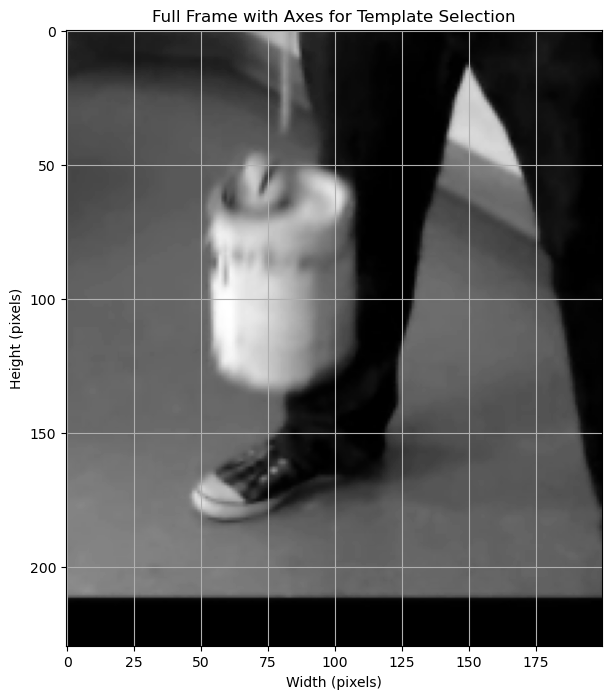

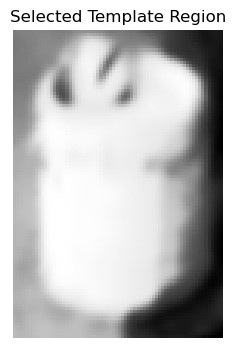

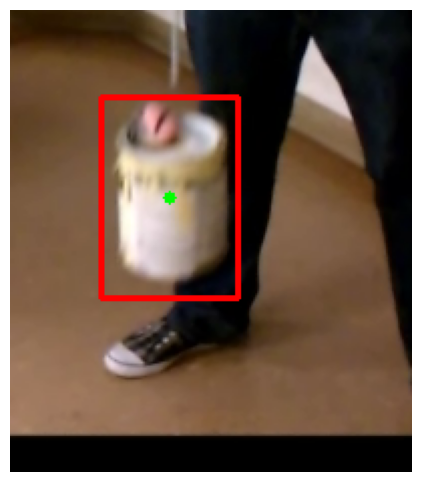

Video saved: videos/camera_1_tracked_final.mp4
Overlayed video saved as 'videos/camera_1_tracked_final.mp4'.
Number of frames: 394


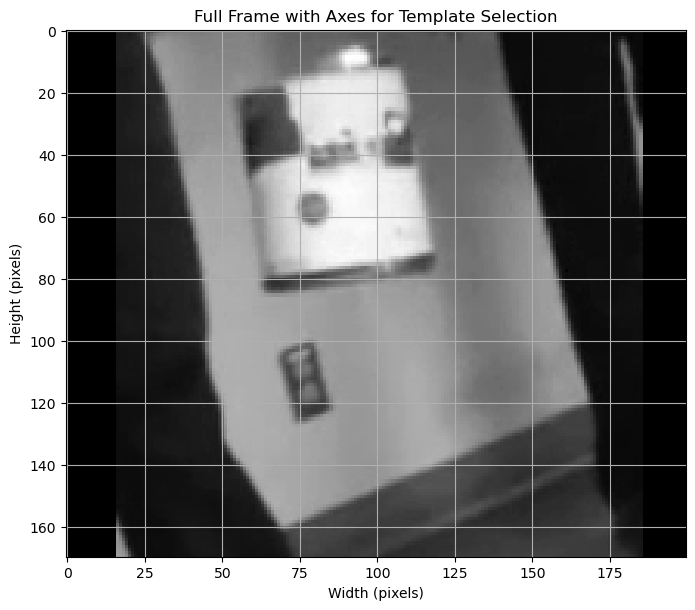

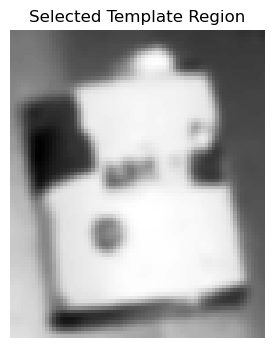

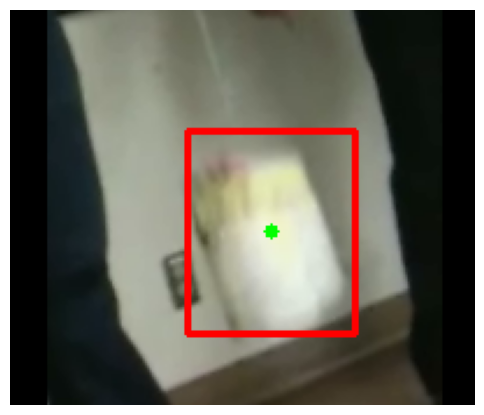

Video saved: videos/camera_3_tracked_final.mp4
Overlayed video saved as 'videos/camera_3_tracked_final.mp4'.
Number of frames: 405


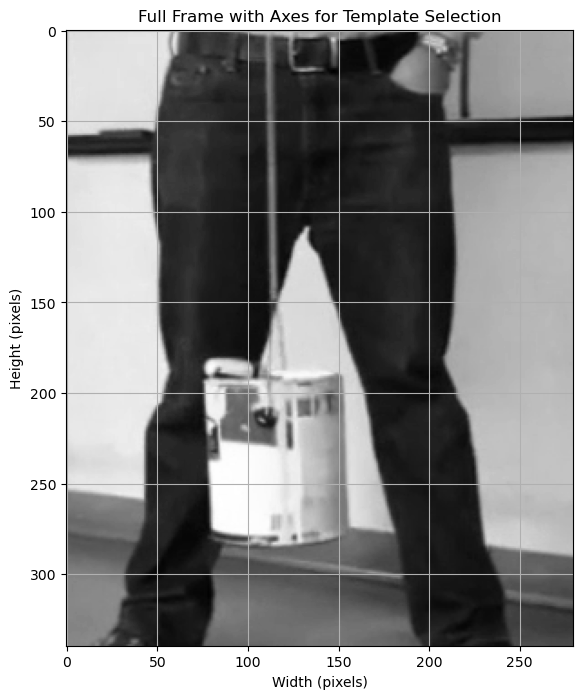

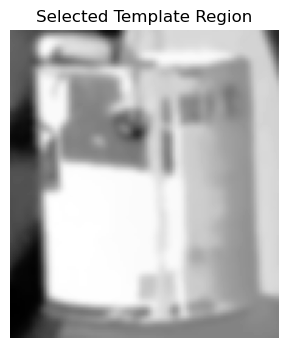

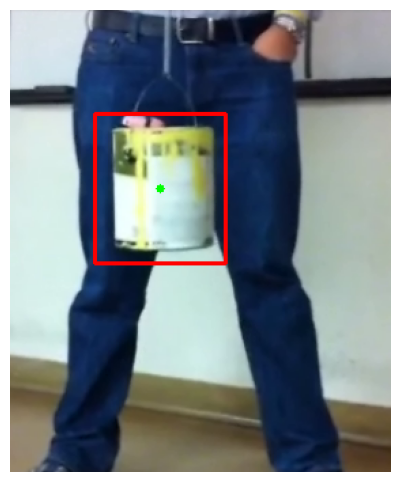

Video saved: videos/camera_2_tracked_final.mp4
Overlayed video saved as 'videos/camera_2_tracked_final.mp4'.


In [168]:
# Using the tracking function to compute the tracking data in x and y direction
cam1_positions = track_object_in_video("camera1_cropped.npz", (45, 43, 68, 100), template_frame_index=100, match_threshold=0.65, max_move_distance=20, output_video='videos/camera_1_tracked_final.mp4', sample_index=100)

cam3_positions = track_object_in_video("camera3_cropped.npz", (52, 0, 72, 87), template_frame_index=50, match_threshold=0.39, max_move_distance=15, output_video='videos/camera_3_tracked_final.mp4', sample_index=200)

cam2_positions = track_object_in_video("camera2_cropped.npz", (67, 180, 96, 110), template_frame_index=80, match_threshold=0.40, max_move_distance=40, output_video='videos/camera_2_tracked_final.mp4', sample_index=100)


In [169]:
# Examining the datasets collected, dimensions are (Frames, Dimensions)

print(cam1_positions.shape)
print(cam2_positions.shape)
print(cam3_positions.shape)

(392, 2)
(405, 2)
(394, 2)


In [170]:
#compress datasets and save them so that all steps dont need to be repeated when reopening the file
save_dataset(cam1_positions, "tracked_datasets/camera1_tracked.npz")
save_dataset(cam2_positions, "tracked_datasets/camera2_tracked.npz")
save_dataset(cam3_positions, "tracked_datasets/camera3_tracked.npz")

Dataset saved successfully to 'tracked_datasets/camera1_tracked.npz'.
Dataset saved successfully to 'tracked_datasets/camera2_tracked.npz'.
Dataset saved successfully to 'tracked_datasets/camera3_tracked.npz'.


In [171]:
# Ensure all datasets are the same shape (392, 2) by taking the last 392 rows
cam1_positions = cam1_positions[-392:, :]
cam2_positions = cam2_positions[-392:, :]
cam3_positions = cam3_positions[-392:, :]

Plots saved: all_x_positions.png, all_y_positions.png in 'plots' folder.


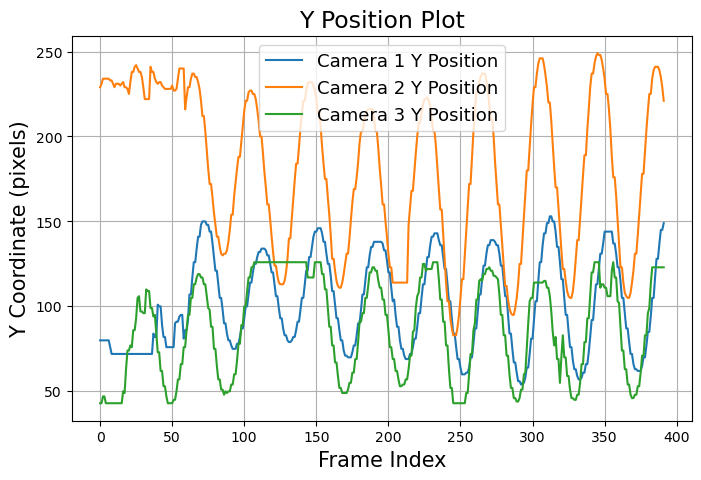

In [193]:
# Function to plot all x and y positions on separate axes with customizable font sizes for titles, labels, and legend

def plot_all_can_positions(position_arrays: list, labels: list, 
                           save_path="plots", 
                           x_title="X Position vs Frame Number for All Cameras", 
                           y_title="Y Position vs Frame Number for All Cameras",
                           xlabel="Frame Number", ylabel_x="X Position (pixels)", ylabel_y="Y Position (pixels)",
                           title_fontsize=14, label_fontsize=12, legend_fontsize=10):
    """
    Plots all x positions and all y positions on separate axes with customizable font sizes for titles, axis labels, and legend.

    Parameters:
        position_arrays (list): A list of numpy arrays where each array has shape (N, 2) and 
                                represents (x, y) positions over frames.
        labels (list): List of dataset names corresponding to each position array.
        save_path (str): Directory where plots will be saved.
        x_title (str): Title for the X position plot.
        y_title (str): Title for the Y position plot.
        xlabel (str): Label for the x-axis.
        ylabel_x (str): Label for the y-axis in the X position plot.
        ylabel_y (str): Label for the y-axis in the Y position plot.
        title_fontsize (int): Font size for the titles.
        label_fontsize (int): Font size for axis labels.
        legend_fontsize (int): Font size of the legend.
    """

    # Generate an array representing the frame numbers, assuming all datasets have the same length
    frame_numbers = np.arange(position_arrays[0].shape[0])  

    # Create a figure for X positions
    plt.figure(figsize=(8, 5))  # Initialize figure with a defined size

    # Iterate through each dataset and plot X positions
    for pos_array, label in zip(position_arrays, labels):
        plt.plot(frame_numbers, pos_array[:, 0], linestyle='-', label=f"{label} X Position")  # Plot X positions

    # Label the x-axis
    plt.xlabel(xlabel, fontsize=label_fontsize)

    # Label the y-axis for X positions
    plt.ylabel(ylabel_x, fontsize=label_fontsize)

    # Set the title for the X position plot
    plt.title(x_title, fontsize=title_fontsize)

    # Add a legend with a customizable font size
    plt.legend(fontsize=legend_fontsize)

    # Enable grid for better visualization
    plt.grid(True)

    # Define the filename and save the X position plot
    x_plot_filename = os.path.join(save_path, "all_x_positions.png")
    plt.savefig(x_plot_filename, dpi=300, bbox_inches='tight')

    # Close the figure to free up memory
    plt.close()

    # Create a figure for Y positions
    plt.figure(figsize=(8, 5))  # Initialize figure with defined size

    # Iterate through each dataset and plot Y positions
    for pos_array, label in zip(position_arrays, labels):
        plt.plot(frame_numbers, pos_array[:, 1], linestyle='-', label=f"{label} Y Position")  # Plot Y positions

    # Label the x-axis
    plt.xlabel(xlabel, fontsize=label_fontsize)

    # Label the y-axis for Y positions
    plt.ylabel(ylabel_y, fontsize=label_fontsize)

    # Set the title for the Y position plot
    plt.title(y_title, fontsize=title_fontsize)

    # Add a legend with a customizable font size
    plt.legend(fontsize=legend_fontsize)

    # Enable grid for better visualization
    plt.grid(True)

    # Define the filename and save the Y position plot
    y_plot_filename = os.path.join(save_path, "all_y_positions.png")
    plt.savefig(y_plot_filename, dpi=300, bbox_inches='tight')

    # Close the figure to free up memory
    #plt.close()

    # Print confirmation message with filenames and save path
    print(f"Plots saved: all_x_positions.png, all_y_positions.png in '{save_path}' folder.")

# Using the function with custom parameters
plot_all_can_positions(
    [cam1_positions, cam2_positions, cam3_positions], 
    ["Camera 1", "Camera 2", "Camera 3"],
    x_title="X Position vs Frame Number",
    y_title="Y Position Plot vs Frame Number",
    xlabel="Frame Index",
    ylabel_x="X Coordinate (pixels)",
    ylabel_y="Y Coordinate (pixels)",
    title_fontsize=17,
    label_fontsize=15,
    legend_fontsize=13
)

In [224]:
# Specifying text sizes used in the next sections
labelsize = 16
titlesize = 18
legendsize = 14

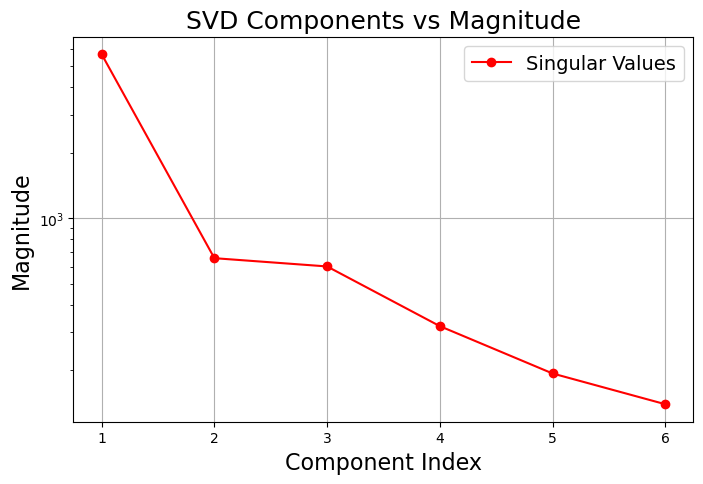

'plots/svd_components_vs_magnitude.png'

In [225]:
# Combine all three datasets into a single matrix X with shape (6, 392)
# Each dataset has shape (392, 2), where columns represent (x, y) positions.
# We transpose them to (2, 392) so that each row represents x or y positions.
# Stacking all three cameras vertically results in a final shape of (6, 392).
X = np.vstack([cam1_positions.T, cam2_positions.T, cam3_positions.T])  # Shape (6, 392)

# Compute Singular Value Decomposition (SVD)
# U: Left singular vectors (6, 6), describes the contribution of each dataset to the modes
# Sigma: Singular values (6,), represents the importance (energy) of each mode
# Vt: Right singular vectors (6, 392), describes temporal patterns of each mode
U, Sigma, Vt = np.linalg.svd(X, full_matrices=False)

# Create a new figure with a defined size
plt.figure(figsize=(8, 5))

# Plot singular values against their component index
plt.plot(np.arange(1, len(Sigma) + 1), Sigma, 'ro-', label="Singular Values")  # Red dots with line

# Label x-axis as "Component Index"
plt.xlabel("Component Index", fontsize = labelsize)

# Label y-axis as "Magnitude" to represent singular values
plt.ylabel("Magnitude", fontsize = labelsize)

# Set the title for the plot
plt.title("SVD Components vs Magnitude", fontsize = titlesize)

# Use logarithmic scale for better visualization of small values
plt.yscale("log")

# Enable grid for readability
plt.grid(True)

# Add legend to indicate what is plotted
plt.legend(fontsize = legendsize)

# Define the filename and save the plot in the output directory
plot_path = os.path.join(output_dir, "svd_components_vs_magnitude.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Return the saved plot path for reference
plot_path

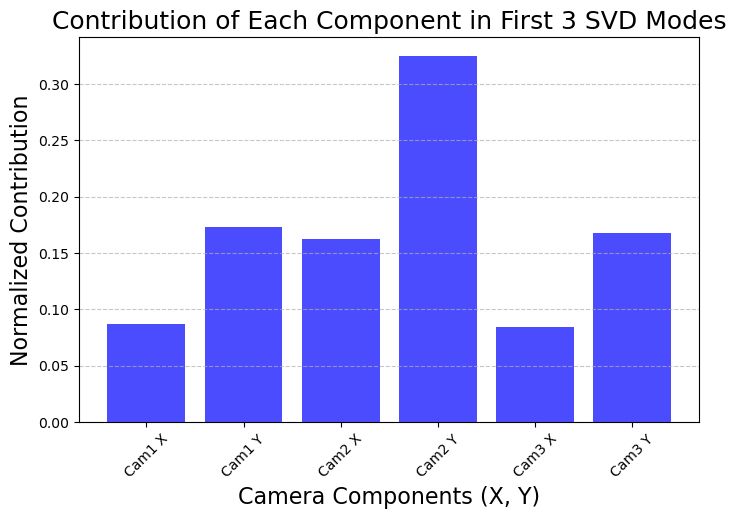

'plots/svd_component_contributions_histogram.png'

In [234]:
# Create a histogram plot for the contribution of each component in the first 3 SVD modes
plt.figure(figsize=(8, 5))

# Compute the absolute squared values of U to represent energy contribution of each component
U_squared = np.square(U)

# Sum only the contributions to the first 3 modes
component_contributions = np.sum(U_squared[:, :3], axis=1) / np.sum(U_squared[:, :3])

# Define labels for components (Cam1 X, Cam1 Y, ..., Cam3 Y)
labels = ["Cam1 X", "Cam1 Y", "Cam2 X", "Cam2 Y", "Cam3 X", "Cam3 Y"]

# Create histogram bars
plt.bar(labels, component_contributions, color='b', alpha=0.7)

# Label axes
plt.xlabel("Camera Components (X, Y)", fontsize=labelsize)
plt.ylabel("Normalized Contribution", fontsize=labelsize)

# Set title
plt.title("Contribution of Each Component in First 3 SVD Modes", fontsize=titlesize)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Enable grid for visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Define the filename and save the plot in the output directory
plot_path = os.path.join(output_dir, "svd_component_contributions_histogram.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Return the saved plot path for reference
plot_path

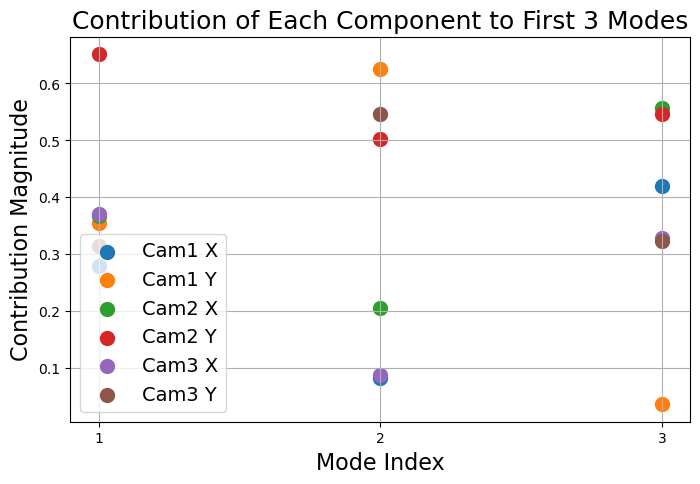

'plots/svd_mode_contributions_larger_dots.png'

In [233]:
# Create figure with larger marker size for better visibility
plt.figure(figsize=(8, 5))

# Overlay dots for individual camera component contributions with larger markers
for i in range(6):  # Iterate over Cam1 X, Cam1 Y, ..., Cam3 Y
    plt.scatter(modes, mode_contributions[i, :], label=labels[i], marker='o', s=100)  # Increased marker size

# Configure plot
plt.xlabel("Mode Index", fontsize = labelsize)
plt.ylabel("Contribution Magnitude", fontsize = labelsize)
plt.title("Contribution of Each Component to First 3 Modes", fontsize = titlesize)
plt.xticks(modes)
plt.legend(fontsize = legendsize, loc="lower left")
plt.grid(True)

# Save the plot
plot_path = os.path.join(output_dir, "svd_mode_contributions_larger_dots.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

# Return saved plot path
plot_path


In [228]:
# Function to overlay the reconstructed models onto original data
# The function plots X and Y positions separately for a selected camera with multiple reduced SVD models
def plot_camera_svd_multiple_k_separate_xy(camera_index, k_values):
    """
    Plots the X and Y positions vs frame number for a selected camera using multiple reduced SVD models.
    Saves separate figures for X and Y plots.

    Parameters:
    - camera_index: int (1 for cam1, 2 for cam2, 3 for cam3)
    - k_values: list of int (number of singular values to use in multiple reduced-order models)
    
    Returns:
    - plot_paths: dict - Paths to the saved X and Y plot images.
    """

    # Dictionary to store paths of the saved plots
    plot_paths = {}

    # Select the correct dataset based on the given camera index
    if camera_index == 1:
        original_data = cam1_positions  # Camera 1 dataset
        label = "Camera 1"  # Label for plotting
    elif camera_index == 2:
        original_data = cam2_positions  # Camera 2 dataset
        label = "Camera 2"  # Label for plotting
    elif camera_index == 3:
        original_data = cam3_positions  # Camera 3 dataset
        label = "Camera 3"  # Label for plotting
    else:
        # Raise an error if an invalid camera index is provided
        raise ValueError("Invalid camera index. Choose 1, 2, or 3.")

    # Create an array representing the frame numbers (assuming all datasets have the same length)
    frames = np.arange(392)

    # Create separate figures for X and Y position plots
    fig_x, ax_x = plt.subplots(figsize=(10, 5))  # Figure for X positions
    fig_y, ax_y = plt.subplots(figsize=(10, 5))  # Figure for Y positions

    # Compute and plot reduced models for each specified k value
    for k in k_values:
        # Extract the first k singular values and vectors for low-rank approximation
        U_k = U[:, :k]  # Left singular vectors (truncated)
        Sigma_k = np.diag(Sigma[:k])  # Singular values (diagonal matrix)
        Vt_k = Vt[:k, :]  # Right singular vectors (truncated)

        # Compute the reduced-order approximation of the dataset
        X_k = U_k @ Sigma_k @ Vt_k

        # Extract the reduced data for the selected camera
        if camera_index == 1:
            reduced_data = X_k[:2, :].T  # First two rows correspond to Camera 1
        elif camera_index == 2:
            reduced_data = X_k[2:4, :].T  # Rows 3-4 correspond to Camera 2
        elif camera_index == 3:
            reduced_data = X_k[4:6, :].T  # Rows 5-6 correspond to Camera 3

        # Plot the reduced X position vs frame number
        ax_x.plot(frames, reduced_data[:, 0], linestyle='--', alpha=0.8, label=f"Reduced X (k={k})")

        # Plot the reduced Y position vs frame number
        ax_y.plot(frames, reduced_data[:, 1], linestyle='--', alpha=0.8, label=f"Reduced Y (k={k})")

    # Plot original data last to ensure it is clearly visible
    ax_x.plot(frames, original_data[:, 0], 'k-', alpha=0.8, linewidth=1.5, label="Original X")
    ax_y.plot(frames, original_data[:, 1], 'k-', alpha=0.8, linewidth=1.5, label="Original Y")

    # Configure the X position plot
    ax_x.set_xlabel("Frame Number", fontsize = labelsize)  # Label x-axis
    ax_x.set_ylabel("X Position", fontsize = labelsize)  # Label y-axis
    ax_x.set_title(f"X Position vs Frame Number ({label})", fontsize = titlesize)  # Set title
    ax_x.legend(fontsize = legendsize)  # Add legend to identify plots
    ax_x.grid(True)  # Enable grid for better visualization

    # Configure the Y position plot
    ax_y.set_xlabel("Frame Number", fontsize = labelsize)  # Label x-axis
    ax_y.set_ylabel("Y Position", fontsize = labelsize)  # Label y-axis
    ax_y.set_title(f"Y Position vs Frame Number ({label})", fontsize = titlesize)  # Set title
    ax_y.legend(fontsize = legendsize)  # Add legend to identify plots
    ax_y.grid(True)  # Enable grid for better visualization

    # Define file paths for saving the plots
    x_plot_path = os.path.join(output_dir, f"svd_x_vs_frame_cam{camera_index}.png")
    y_plot_path = os.path.join(output_dir, f"svd_y_vs_frame_cam{camera_index}.png")

    # Save the figures
    fig_x.savefig(x_plot_path, dpi=300, bbox_inches='tight')
    fig_y.savefig(y_plot_path, dpi=300, bbox_inches='tight')

    # Close the figures to free up memory
    plt.close(fig_x)
    plt.close(fig_y)

    # Store the paths of the saved plots in a dictionary
    plot_paths["X"] = x_plot_path
    plot_paths["Y"] = y_plot_path

    # Return the dictionary containing paths to the saved plots
    return plot_paths

In [229]:
# Plotting reconstructed models for camera 1
plot_camera_svd_multiple_k_separate_xy(camera_index=1, k_values=[1, 3, 4])

{'X': 'plots/svd_x_vs_frame_cam1.png', 'Y': 'plots/svd_y_vs_frame_cam1.png'}

In [230]:
# Plotting reconstructed models for camera 2
plot_camera_svd_multiple_k_separate_xy(camera_index=2, k_values=[1, 2, 3])

{'X': 'plots/svd_x_vs_frame_cam2.png', 'Y': 'plots/svd_y_vs_frame_cam2.png'}

In [231]:
# Plotting reconstructed models for camera 3
plot_camera_svd_multiple_k_separate_xy(camera_index=3, k_values=[1,3, 4])

{'X': 'plots/svd_x_vs_frame_cam3.png', 'Y': 'plots/svd_y_vs_frame_cam3.png'}